In [1]:
from __future__ import print_function
import os
#libraries
import numpy as np
import pandas as pd
import python_speech_features
import librosa
import librosa.display
import matplotlib.pyplot as plt

In [2]:
#加载数据

sampling_rate = 1600

def load_data(path = None):


    if path == None:
        path = '../data/wav'

    files = os.listdir(path)

    sample = []
    for file in files:
        sample.append([path+'/'+file,file[0:2],file[2:5],file[5]])
    samples = pd.DataFrame(sample,columns=['audio_name','actor','text','emotion'])

    emotions = ["A",'E','F','L','W','T','N']
    emotions_english = ["anxiety",'disgust','happy','boredom','anger','sadness','neutral']
    #mapping = {'A': 0, 'E': 1, 'F':2, 'L':3, 'W':4, 'T':5, 'N':6}
    mapping = {'A': 'anxiety', 'E': 'disgust', 'F':'happy', 'L':'boredom', 'W':'anger', 'T':'sadness', 'N':'neutral'}
    samples = samples.replace({'emotion':mapping})

    return samples,emotions_english

In [3]:
samples,emotion= load_data(path = "data/wav")
samples

,audio_name,actor,text,emotion
0,data/wav/03a01Fa.wav,03,a01,happy
1,data/wav/03a01Nc.wav,03,a01,neutral
2,data/wav/03a01Wa.wav,03,a01,anger
3,data/wav/03a02Fc.wav,03,a02,happy
4,data/wav/03a02Nc.wav,03,a02,neutral
5,data/wav/03a02Ta.wav,03,a02,sadness
6,data/wav/03a02Wb.wav,03,a02,anger
7,data/wav/03a02Wc.wav,03,a02,anger
8,data/wav/03a04Ad.wav,03,a04,anxiety
9,data/wav/03a04Fd.wav,03,a04,happy


In [4]:
def import_wave_wrapper(df , modify = True):

    Y = []
    SR = []
    l = []

    for i in range(len(df)):
        y,sr = librosa.load(df["audio_name"][i],sr=None)
        Y.append(y)
        l.append(len(y))

    if modify:
        df["sound"] = Y
        df["length"] = l
    else:
        return Y,l
    
import_wave_wrapper(samples)

In [5]:
def silence_size(y,size = 2, threshold = 0.01):

    coord = []
    size = 5
    for i in range(size,len(y)-size):
        if np.max(abs(y[i-size:i+size])) < threshold:
            coord.append(i)

    return len(coord)


In [6]:
def ratio(df,threshold = 0.02, modify = True):

    ratios = []

    for i in range(len(df)):
        sound = df["sound"][i]
        s = silence_size(sound)
        l = len(sound)
        ratio = s/(l-s)
        ratios.append(ratio)

    if modify:
        df["ratio"] = ratios
    else:
        return ratios

In [7]:
def extract_feature(df,f, name, modify = True):

    mean = []
    sd = []
    median = []
    maxi = []
    mini = []

    for i in range(len(df)):
        #extract the data
        inter = f(df["sound"][i],1600)

        #compute the actual statistics
        mean.append(np.mean(inter))
        sd.append(np.std(inter))
        median.append(np.median(inter))
        maxi.append(np.max(inter))
        mini.append(np.min(inter))

    if modify:
        df[name +"_mean"] = mean
        df[name +"_sd"] = sd
        df[name +"_median"] = median
        df[name +"_max"] = maxi
        df[name + "_min"] = mini
    else: return mean,sd,median,maxi,mini

In [8]:
#librosa提取特征
extract_feature(samples, librosa.feature.mfcc, "mfcc")
extract_feature(samples, librosa.feature.spectral_centroid, "spectral_centroid")
extract_feature(samples, librosa.feature.spectral_rolloff, "spectral_rolloff")
extract_feature(samples, python_speech_features.logfbank , "logfbank")
extract_feature(samples, python_speech_features.ssc, "spectral_subband_centroid")
ratio(samples)

In [9]:
samples

,audio_name,actor,text,emotion,sound,length,mfcc_mean,mfcc_sd,mfcc_median,mfcc_max,...,logfbank_sd,logfbank_median,logfbank_max,logfbank_min,spectral_subband_centroid_mean,spectral_subband_centroid_sd,spectral_subband_centroid_median,spectral_subband_centroid_max,spectral_subband_centroid_min,ratio
0,data/wav/03a01Fa.wav,03,a01,happy,"[0.0006713867, 0.0030822754, 0.002532959, 0.00...",30372,-1.156849,57.081921,1.594942,181.907614,...,3.828003,-11.118026,-1.747629,-23.456770,347.468976,220.523908,325.439181,773.963810,13.322917,0.374859
1,data/wav/03a01Nc.wav,03,a01,neutral,"[0.0002746582, 9.1552734e-05, 0.00039672852, 0...",25780,0.757918,63.445792,3.182906,207.101038,...,4.281498,-11.513314,-1.679515,-22.091007,347.383668,220.799653,324.233671,776.460768,13.664885,0.483912
2,data/wav/03a01Wa.wav,03,a01,anger,"[0.0, 3.0517578e-05, -0.00015258789, -3.051757...",30045,-2.663930,50.447978,-1.850918,198.154961,...,4.911147,-9.426313,-0.904726,-23.568426,347.582206,220.397060,324.581261,774.650185,13.646360,0.365496
3,data/wav/03a02Fc.wav,03,a02,happy,"[0.0007019043, 0.0025024414, 0.0026855469, -0....",32100,-1.856563,46.828013,0.896004,127.197303,...,4.045285,-10.127412,-1.403611,-22.315049,347.577842,220.568540,324.318674,776.111718,13.093610,0.388408
4,data/wav/03a02Nc.wav,03,a02,neutral,"[6.1035156e-05, -0.00030517578, -0.00015258789...",23037,3.202259,56.796473,4.547162,212.748466,...,4.042340,-10.783794,-1.857916,-21.775066,347.396347,220.859913,326.009732,778.454506,13.651087,0.332620
5,data/wav/03a02Ta.wav,03,a02,sadness,"[0.0, 0.0, 0.00021362305, 0.0, 0.00021362305, ...",27771,3.445987,51.882410,4.855104,168.955014,...,3.638183,-10.524791,-0.214248,-20.816228,347.570229,220.681759,324.752729,775.877773,12.754102,0.330092
6,data/wav/03a02Wb.wav,03,a02,anger,"[0.0026550293, 0.0032043457, 0.004119873, 0.00...",33978,-0.985218,46.110839,1.097086,151.277580,...,4.495470,-9.154204,-1.379479,-24.151766,347.644710,220.440012,323.969012,777.681375,13.000605,0.263029
7,data/wav/03a02Wc.wav,03,a02,anger,"[9.1552734e-05, 0.00012207031, 6.1035156e-05, ...",23969,-4.869508,55.266503,-2.851796,181.626094,...,4.925279,-9.904074,-0.615395,-25.840668,347.580547,220.444021,324.032678,773.414681,13.692046,0.323012
8,data/wav/03a04Ad.wav,03,a04,anxiety,"[0.00015258789, -0.0015869141, -0.00091552734,...",24078,-0.635298,41.742440,0.254178,121.684044,...,3.830843,-9.178499,-1.432067,-22.775395,347.615011,220.467040,324.047753,782.163085,13.057375,0.210132
9,data/wav/03a04Fd.wav,03,a04,happy,"[3.0517578e-05, -9.1552734e-05, -0.0002746582,...",27149,-3.146874,58.154582,1.928674,159.409665,...,4.467920,-11.387694,-0.885219,-24.074460,347.521555,220.613806,324.854840,778.096053,13.302316,0.450810


In [10]:
samples.to_csv("features/berlin_features.csv",index=False)
import_wave_wrapper(samples)

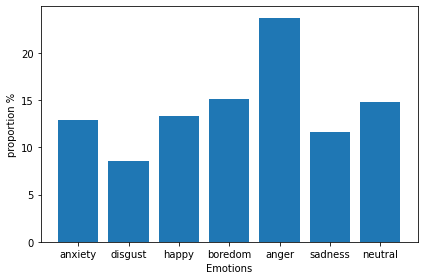

In [13]:
proportion = []
total = len(samples.index)
for e in emotion:
    proportion.append(100*len(samples[samples["emotion"]==e].index)/total)
    

x = np.arange(7)

fig, ax = plt.subplots()
plt.bar(x, proportion)
plt.xticks(x, emotion)
plt.xlabel("Emotions")
plt.ylabel("proportion %")
plt.tight_layout()
plt.savefig('results/proportion.png',dpi = 1000)
plt.show()

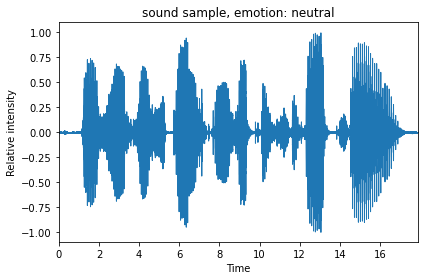

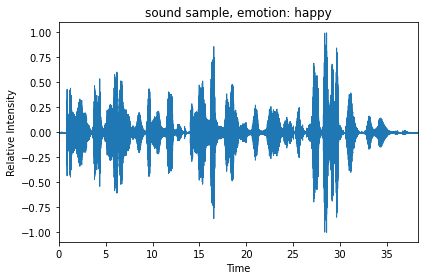

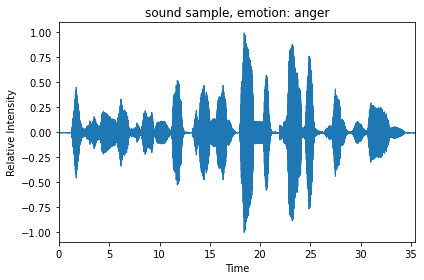

In [15]:
i =23
y = samples["sound"][i]
librosa.display.waveplot(y,1600)
plt.ylabel("Relative intensity")
plt.title("sound sample, emotion: {}".format(samples["emotion"][i]))
plt.tight_layout()
plt.savefig("results/sound_samples.png", dpi =100)
plt.show()

i = 225
y = samples["sound"][i]
librosa.display.waveplot(y,1600)
plt.ylabel("Relative Intensity")
plt.title("sound sample, emotion: {}".format(samples["emotion"][i]))
plt.tight_layout()
plt.savefig("results/sound_samples_1.png", dpi =100)
plt.show()


i = 400
y = samples["sound"][i]
librosa.display.waveplot(y,1600)
plt.ylabel("Relative Intensity")
plt.title("sound sample, emotion: {}".format(samples["emotion"][i]))
plt.tight_layout()
plt.savefig("results/sound_samples_2.png", dpi =100)
plt.show()